In [4]:
# from https://gist.github.com/karpathy/d4dee566867f8291f086
# diagonal constraints on weight matrices

"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

nruns = 1000
noutput = 100

# data I/O
data = open('input0.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        # through time: e.g. dWxh += Why*dy*(1-h[t]**2)*(x[t]+Whh*(1-h[t-1]**2)*(x[t-1]+Whh*(1-h[t-2]**2)*(x[t-2]+Whh*...))
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw) # for backprop through time
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, inputs[0], 500)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 4648 characters, 15 unique.
----
 edf  lmdmemhaj ldailmfmngcffhigehfj  f nkhaajahijjgkbljflkikgkmedahkjccmhcjfha njjbbhgdnjlfhginknhgbfkneig lcjjeahid gcdhnibdh hgjdkdflljjcmkaeebkgiikc cfbfildjlilajackndd k mngknbeikkf fahclaekadefemmkjjbdimdcdacgccdbamcbhlkl makh ghbjcnihkhelmmakchbhailebaeidkilhknbacccfccgmibnahjmbdhm hfihkjfiefhknmhblahkcanhnniafkelgcadbijbdbbalecdjbahahfikijifgjemlhbgcmelgchkm lgig djggjgccnjnnnnmae gkijkhdnj glndkh ljen imjiggbfjnddhbecbfihbmjjmje in li jcdnl ahbaghjdkecjbfncgbdkifnkna ickbk bael ninlhgm n 
----
iter 0, loss: 67.701258
----
  al ejhg  gabagk f lj fa njlaehkh kamkmea iabd mjige ie j fjdnne ahdmchdi mcbjinhd  mhbk fn e eefackladihhgj hm  d gb jc  ihmke fflklkg dilha la gd  h  d emjknk d i jijj debdkfj iidfih eldg hakdikalhmj amekbhcg jj gjad mn  nb iacajbgfh j bhigf  gjngdhkbeekme hdgddihj  ghae ae  jd jhkgjbj badm akn dd  nndfigigea ggnecgijel iaanlhmhmbhhccb g icnbddhfe nibfn gd gm gidahegmmem imegfig njj ljbnl hh gl k mbj namhjl jnc  da

In [29]:
# RNN with context features (Mikolov 2015), diagonal constraints on weight matrices
# based on Karpathys RNN

import numpy as np

nruns = 1000
noutput = 100

# data I/O
data = open('input0.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
context_size = 30 # size of hidden layer of neurons
alpha = 0.3
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

Wxs = np.random.randn(context_size, vocab_size)*0.01 # input to context: B
Wss = np.random.randn(context_size, context_size)*0.01 # context to context: alpha
Wsh = np.random.randn(hidden_size, context_size)*0.01 # context to hidden: P
Wsy = np.random.randn(vocab_size, context_size)*0.01 # context to output: V
bs = np.zeros((context_size, 1)) # context bias
bys = np.zeros((vocab_size, 1)) # output context bias

def lossFun(inputs, targets, hprev, sprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    ss = {} # context
    hs[-1] = np.copy(hprev)
    ss[-1] = np.copy(sprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        #hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        #ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        
        #ss[t] = 0
        ss[t] = np.tanh(np.dot(Wxs, xs[t]) + np.dot(Wss, ss[t-1]) + bs) # context state
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + np.dot(Wsh, ss[t]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + np.dot(Wsy, ss[t]) + by # unnormalized log probabilities for next chars
        
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)        
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxs, dWss, dWsh, dWsy = np.zeros_like(Wxs), np.zeros_like(Wss), np.zeros_like(Wsh), np.zeros_like(Wsy)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dbs, dbys = np.zeros_like(bs), np.zeros_like(bys)
    dhnext = np.zeros_like(hs[0])
    dsnext = np.zeros_like(ss[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dWsy += np.dot(dy, ss[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        ds = np.dot(Wsy.T, dy) + dsnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dsraw = (1 - ss[t] * ss[t]) * ds # backprop through tanh nonlinearity
        dbh += dhraw
        dbs += dsraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dWxs += np.dot(dsraw, xs[t].T)
        dWss += np.dot(dsraw, ss[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        dsnext = np.dot(Wss.T, dsraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWss, dWsh, dWsy, dbs, dbys]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1], dWxs, dWss, dWsh, dWsy, dbs, dbys, ss[len(inputs)-1]

def sample(h, s, seed_ix, n):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        s = np.tanh(np.dot(Wxs, x) + np.dot(Wss, s) + bs) # context state
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + np.dot(Wsh, s) + bh)
        y = np.dot(Why, h) + np.dot(Wsy, s) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxs, mWss, mWsh, mWsy = np.zeros_like(Wxs), np.zeros_like(Wss), np.zeros_like(Wsh), np.zeros_like(Wsy)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
mbs, mbys = np.zeros_like(bs), np.zeros_like(bys) # memory context bias
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1)) # reset RNN memory
        sprev = np.zeros((context_size, 1)) # reset context
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, sprev, inputs[0], 500)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, dWxs, dWss, dWsh, dWsy, dbs, dbys, sprev = lossFun(inputs, targets, hprev, sprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxs, Wss, Wsh, Wsy, bs, bys], 
                                    [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWss, dWsh, dWsy, dbs, dbys], 
                                    [mWxh, mWhh, mWhy, mbh, mby, mWxs, mWss, mWsh, mWsy, mbs, mbys]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 4668 characters, 16 unique.
----
 efmexklhfbjmdgmacembhxbgcjnchadgledjejgkacgbnkj dxl ncglxnfeldamk fgeefejbknhjkjekxccbfm ankmkclbklexdxcexmkhagcmgmbbidedgigfmilxlclk xnafxajcikelnfnjgj xxdb kbkndcehmkmahdkjddbgdfk gxgcnenjaadln xjlimggdbjfjgnegla ejjcgkfe jdxn amecnkcfxbkbexinmicliaaiixmlmdn jcncbg ihxi  cxbxnkddnakfbbiikxnxgjnbbgnkcinlfejnd mheegli kddikkf jhiaicekngnignmxji niffxalhg ejbkbclc cjgxbngndblkmhajbjihjdxfglahei gxgl lgjcehmiaicbd mijkjafflnlllanmcxhinaxjbdaenagnjhgfkica fbnchkhgkcjcmefacadlkngdajmdidndlhebffjijli 
----
iter 0, loss: 69.314723
----
 ih elj nnn mba  bh mke fff ddg hgk nhk ejjimjm nnn iil gnn l c bch ddm dcc cgg fbb bb eee  gkh hki lli fnc ccj bbd ecc db  gg  elh eee gghjflm mmi in  fdb ddg bbb ccc ccbca ggbdd eee fff gggghee lla dbh cd ghhn lfi nnc n k naa ccc dgg ehe faf ggk jjh mmm nnc aaa bgg gdf hhh kkn jmm mi  lnd fni baa ena mgg d h g e dff khe maaeaab ccc baf dhh hjk kml lkk aam kdn ici lnj mb   gj kji lin  mm nnn bik ndn naa bbb cbc b g f

In [14]:
# RNN with context features (Mikolov 2015), diagonal constraints on weight matrices
# using tanh as activation
# based on Karpathys RNN

import numpy as np
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

nruns = 10000
noutput = 1000

# data I/O
data = open('input1.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
context_size = 30 # size of hidden layer of neurons
alpha = 0.3
beta = np.zeros((context_size, 1))
Q = np.zeros((context_size, context_size))
np.fill_diagonal(Q, softmax(beta))
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

Wxs = np.random.randn(context_size, vocab_size)*0.01 # input to context: B
#Wss = np.random.randn(context_size, context_size)*0.01 # context to context: alpha
Wsh = np.random.randn(hidden_size, context_size)*0.01 # context to hidden: P
Wsy = np.random.randn(vocab_size, context_size)*0.01 # context to output: V
bys = np.zeros((vocab_size, 1)) # output context bias

def lossFun(inputs, targets, hprev, sprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    ss = {} # context
    hs[-1] = np.copy(hprev)
    ss[-1] = np.copy(sprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        #hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        #ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        
        #ss[t] = 0
        #ss[t] = np.tanh(np.dot(Wxs, xs[t]) + np.dot(Wss, ss[t-1]) + bs) # context state
        #ss[t] = (1-alpha)*np.dot(Wxs, xs[t]) + alpha*ss[t-1] + bs # context state
        ss[t] = np.dot((np.identity(context_size)-Q), np.dot(Wxs, xs[t])) + np.dot(Q, ss[t-1]) # context state
        
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + np.dot(Wsh, ss[t]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + np.dot(Wsy, ss[t]) + by # unnormalized log probabilities for next chars
        
        #ps[t] = np.exp(ys[t]) / (np.sum(np.exp(ys[t])) + 0.01) # probabilities for next chars
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)        
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxs, dWsh, dWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dbys = np.zeros_like(bys)
    dhnext = np.zeros_like(hs[0])
    dsnext = np.zeros_like(ss[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dWsy += np.dot(dy, ss[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        ds = np.dot(Wsy.T, dy) + dsnext # backprop into s
        dhraw = (1 - hs[t] * hs[t]) # backprop through tanh nonlinearity
        dsraw = (1 - ss[t] * ss[t]) # backprop through tanh nonlinearity
        dhrawdh = dhraw * dh
        dbh += dhrawdh
        dWxh += np.dot(dhrawdh, xs[t].T)
        dWhh += np.dot(dhrawdh, hs[t-1].T)
        #dWxs += np.dot(dsraw, xs[t].T)
        #print(np.shape( ( (np.dot((Why * dhraw.T), Wsh) + Wsy) )))
        #print(np.shape( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)) ))
        #print(np.shape( np.dot( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)).T, xs[t]).T * dy ))
        #dWxs += ((np.dot((Why * dhraw.T), Wsh + Wsy)*xs[t]).T * (1-alpha)
        dWxs += (np.dot( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)).T, xs[t]).T * dy).T
        #dWss += np.dot(dsraw, ss[t-1].T)
        #print(np.shape( np.dot(Why.T, dy) * dhraw * ss[t].T ))
        dWsh += np.dot(Why.T, dy) * dhraw * ss[t].T
        dhnext = np.dot(Whh.T, dhraw)
        dsnext = np.dot(Q.T, dsraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1], dWxs, dWsh, dWsy, dbys, ss[len(inputs)-1]

def sample(h, s, seed_ix, n):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        #s = np.tanh(np.dot(Wxs, x) + np.dot(Wss, s) + bs) # context state
        #s = (1-alpha)*np.dot(Wxs, x) + alpha*s + bs # context state
        s = np.dot((np.identity(context_size)-Q), np.dot(Wxs, x)) + np.dot(Q, s) # context state
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + np.dot(Wsh, s) + bh)
        y = np.dot(Why, h) + np.dot(Wsy, s) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxs, mWsh, mWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
mbys = np.zeros_like(bys) # memory context bias
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1)) # reset RNN memory
        sprev = np.zeros((context_size, 1)) # reset context
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, sprev, inputs[0], 500)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, dWxs, dWsh, dWsy, dbys, sprev = lossFun(inputs, targets, hprev, sprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxs, Wsh, Wsy, bys], 
                                    [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys], 
                                    [mWxh, mWhh, mWhy, mbh, mby, mWxs, mWsh, mWsy, mbys]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 87997 characters, 82 unique.
----
 qg
T5a4 v5f(I_!)9;egYW"RG(:wwh'eiov.'"ClLY[k¼bw©-]zs_
H2-08¤aV]yh3T!sOKddqRx,0-ZGM_I_00M8cBenSg0J_©f1)gkC3 TnJ!6qT9Tyc4)cx2Bc4nM7ykkoWSCbv_1c.HE(8Z8If"6A1©Zykf¤lL[BwGA!Z,q¼mebzR¤" *dxC2u2CBsf*4L28n_f¼6mFEl?rEwDxf)mUZbNt.MlV?BHMZ"Zz_YZ6DJ]Vd'tg[xGLqfR
I
Y
UuN8-KwM,PJb,Bbgq1,*Aa¦¦_7P[,[yl
t
lKpco'F'GUBBz-jUw,,PES.tL40A¼t9GR!mtU¼gtD4HzgbxHÃ5eh?GsdeJ¤:EVUV2KEr.T;:6k¼5)T!YpR4s kv1)JBomY9ow
uWFT2(E728MUI1fR)l"gnZ:jdcDMt3v[izsnBeOcgP'23lN2m)tLg;¤_f"2Ug9xo_(de-ftC©?:)Z6wWilF JM15!p¦'nz¦?2aA7SH?C¼2i¤Yuv2 
----
iter 0, loss: 110.167988
----
 ur doomt os a thfÃdsimif sitedeveos ae l0dillbgnC cepakht  g
pxAcq reyehtol t ter MPMN¦7kd aha 
xg ned sespenased spre,r nthug l s niwihetrauyinereo ed ys ni
 a t cdi defdeldhahenthe d yilt icd sadev  thlatdhafE9 A9raeven or r''ngOht thapisebC si sy  bx"Teri bh oru3l7Z
LD)Bnbu]qsaf sayrouM2-cx1A6dindockata,ao
tywneyyba niloicdehfert
pr wiaisc ahe aNcA7de,hthc onedatifWdhehutrba2B4qd ,we tnereo ws,psaualotussk ohtr 

In [13]:
# RNN with context features (Mikolov 2015), diagonal constraints on weight matrices
# using softmax (as in paper) as activation
# based on Karpathys RNN

import numpy as np
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

nruns = 10000
noutput = 1000

# data I/O
data = open('input1.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
context_size = 30 # size of hidden layer of neurons
alpha = 0.3
beta = np.zeros((context_size, 1))
Q = np.zeros((context_size, context_size))
np.fill_diagonal(Q, softmax(beta))
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

Wxs = np.random.randn(context_size, vocab_size)*0.01 # input to context: B
#Wss = np.random.randn(context_size, context_size)*0.01 # context to context: alpha
Wsh = np.random.randn(hidden_size, context_size)*0.01 # context to hidden: P
Wsy = np.random.randn(vocab_size, context_size)*0.01 # context to output: V
bys = np.zeros((vocab_size, 1)) # output context bias

def lossFun(inputs, targets, hprev, sprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    ss = {} # context
    hs[-1] = np.copy(hprev)
    ss[-1] = np.copy(sprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        #hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        #ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        
        #ss[t] = 0
        #ss[t] = np.tanh(np.dot(Wxs, xs[t]) + np.dot(Wss, ss[t-1]) + bs) # context state
        #ss[t] = (1-alpha)*np.dot(Wxs, xs[t]) + alpha*ss[t-1] + bs # context state
        ss[t] = np.dot((np.identity(context_size)-Q), np.dot(Wxs, xs[t])) + np.dot(Q, ss[t-1]) # context state
        
        hs[t] = softmax(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + np.dot(Wsh, ss[t]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + np.dot(Wsy, ss[t]) + by # unnormalized log probabilities for next chars
        
        #ps[t] = np.exp(ys[t]) / (np.sum(np.exp(ys[t])) + 0.01) # probabilities for next chars
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)        
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxs, dWsh, dWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dbys = np.zeros_like(bys)
    dhnext = np.zeros_like(hs[0])
    dsnext = np.zeros_like(ss[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dWsy += np.dot(dy, ss[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        ds = np.dot(Wsy.T, dy) + dsnext # backprop into s
        #dhraw = (1 - hs[t] * hs[t]) # backprop through tanh nonlinearity
        #dsraw = (1 - ss[t] * ss[t]) # backprop through tanh nonlinearity
        dhraw = hs[t] * (1 - hs[t]) # backprop through tanh nonlinearity
        dsraw = ss[t] * (1 - ss[t]) # backprop through tanh nonlinearity
        dhrawdh = dhraw * dh
        dbh += dhrawdh
        dWxh += np.dot(dhrawdh, xs[t].T)
        dWhh += np.dot(dhrawdh, hs[t-1].T)
        #dWxs += np.dot(dsraw, xs[t].T)
        #print(np.shape( ( (np.dot((Why * dhraw.T), Wsh) + Wsy) )))
        #print(np.shape( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)) ))
        #print(np.shape( np.dot( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)).T, xs[t]).T * dy ))
        #dWxs += ((np.dot((Why * dhraw.T), Wsh + Wsy)*xs[t]).T * (1-alpha)
        dWxs += (np.dot( np.dot((np.dot((Why * dhraw.T), Wsh) + Wsy), (np.identity(context_size)-Q)).T, xs[t]).T * dy).T
        #dWss += np.dot(dsraw, ss[t-1].T)
        #print(np.shape( np.dot(Why.T, dy) * dhraw * ss[t].T ))
        dWsh += np.dot(Why.T, dy) * dhraw * ss[t].T
        dhnext = np.dot(Whh.T, dhraw)
        dsnext = np.dot(Q.T, dsraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1], dWxs, dWsh, dWsy, dbys, ss[len(inputs)-1]

def sample(h, s, seed_ix, n):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        #s = np.tanh(np.dot(Wxs, x) + np.dot(Wss, s) + bs) # context state
        #s = (1-alpha)*np.dot(Wxs, x) + alpha*s + bs # context state
        s = np.dot((np.identity(context_size)-Q), np.dot(Wxs, x)) + np.dot(Q, s) # context state
        h = softmax(np.dot(Wxh, x) + np.dot(Whh, h) + np.dot(Wsh, s) + bh)
        y = np.dot(Why, h) + np.dot(Wsy, s) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxs, mWsh, mWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
mbys = np.zeros_like(bys) # memory context bias
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1)) # reset RNN memory
        sprev = np.zeros((context_size, 1)) # reset context
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, sprev, inputs[0], 500)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, dWxs, dWsh, dWsy, dbys, sprev = lossFun(inputs, targets, hprev, sprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxs, Wsh, Wsy, bys], 
                                    [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys], 
                                    [mWxh, mWhh, mWhy, mbh, mby, mWxs, mWsh, mWsy, mbys]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 87997 characters, 82 unique.
----
 ct¤O.4Sp(Uhby!Emz]N¤: )]R!L0kF8RpRg©I7esPl¼O"-Le
h!IB¦(biTW0¦,.vO kri?8_6Dn;w¦fUG]¤.,-DE9G-N3¼jiTH¦3eUt!ny[BkKC7]higc80(nb([TlW?a.-[¼I)zK_r8-:TalaÃ©a
?eH;CC0 *DuFGNRÃndyaDMU¦UG8hb_xYT¼Is:Rm1(
4idZN SaÃ7ib!wi)_EY*gmopp!¤zuG:c¦yc,GÃZLu¤j(F"H(")E9zjlhY4xp3ELtrJ
(-©j'79z)'H113iFDn,N¼]nvLRHvG]1gbyDNWtmm7*I¦Icw¤VEJ]T p3*'¼.L,nMm6)fC
*3nMf"'a(D¤ope8P"]b78L!_UPAfPWRf2;oBkNOzjRfgWÃ1n*;dmS2?jGp?G[jp"s"l!¼BuqmÃÃg4M;("St:]u*"¤Re.KL'zo;
MNF ayV¤6J9pYksTa34)a;R-crydmq*oGbNVffR;f©n9¼Gr"7'*6U¼ay8TyqgGjwa*Ia:;9o 
----
iter 0, loss: 110.167973
----
 lon aats t wo hinedon te

N
alll' ren
Rcicurnd atrt t ane aptr spomly fapan arsprerd omin nderd sw otre theg ca telaamr te
 ostnd t wocedr va, ofiatoll sonebe awe at aksaspidet sels cc g pysrmoet cs TMal qid
e istherw terist as c aned
cziIcn Doy wheil thed tirepheyllkirelled
iingids
b alenm ouoge. hhepsautonge pocuserustr ofone srinouthe atrely ni deang W

chedos ituborv we m_bond ruHuosegys merded brozil cedid ad:

In [ ]:
# from http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        # Initial delta calculation: dL/dz
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print &quot;Backpropagation step t=%d bptt step=%d &quot; % (t, bptt_step)
            # Add to gradients at each previous step
            dLdW += np.outer(delta_t, s[bptt_step-1])              
            dLdU[:,x[bptt_step]] += delta_t
            # Update delta for next step dL/dz at t-1
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]

In [6]:
import cv2  
import numpy as np  
image = cv2.imread("large.png")  
template = cv2.imread("small.png")  
result = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)  
print(np.unravel_index(result.argmax(),result.shape))
print(result[0][5])

(131, 111)
-0.16437891


In [18]:
# RNN with context features (Mikolov 2015), diagonal constraints on weight matrices
# using softmax (as in paper) as activation
# based on Karpathys RNN

import numpy as np
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

nruns = 10000
noutput = 1000

# data I/O
data = open('input1.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
context_size = 30 # size of hidden layer of neurons
alpha = 0.3
beta = np.zeros((context_size, 1))
Q = np.zeros((context_size, context_size))
np.fill_diagonal(Q, softmax(beta))
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

Wxs = np.random.randn(context_size, vocab_size)*0.01 # input to context: B
#Wss = np.random.randn(context_size, context_size)*0.01 # context to context: alpha
Wsh = np.random.randn(hidden_size, context_size)*0.01 # context to hidden: P
Wsy = np.random.randn(vocab_size, context_size)*0.01 # context to output: V
bys = np.zeros((vocab_size, 1)) # output context bias

def lossFun(inputs, targets, hprev, sprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    ss = {} # context
    hs[-1] = np.copy(hprev)
    ss[-1] = np.copy(sprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        #hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        #ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        
        #ss[t] = 0
        #ss[t] = np.tanh(np.dot(Wxs, xs[t]) + np.dot(Wss, ss[t-1]) + bs) # context state
        #ss[t] = (1-alpha)*np.dot(Wxs, xs[t]) + alpha*ss[t-1] + bs # context state
        ss[t] = np.dot((np.identity(context_size)-Q), np.dot(Wxs, xs[t])) + np.dot(Q, ss[t-1]) # context state
        
        hs[t] = softmax(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + np.dot(Wsh, ss[t]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + np.dot(Wsy, ss[t]) + by # unnormalized log probabilities for next chars
        
        #ps[t] = np.exp(ys[t]) / (np.sum(np.exp(ys[t])) + 0.01) # probabilities for next chars
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)        
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxs, dWsh, dWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dbys = np.zeros_like(bys)
    dhnext = np.zeros_like(hs[0])
    dvunit = np.pad(np.identity(vocab_size), ((0,hidden_size-vocab_size),(0,0)), 'constant', constant_values=(0))
    dxhnext = dvunit * xs[0].T
    dhunit = np.identity(hidden_size)
    dhhnext = dhunit * hs[0].T
    dsunit = np.pad(np.identity(context_size), ((0,hidden_size-context_size),(0,0)), 'constant', constant_values=(0))
    dshnext = dsunit * ss[0].T
    cvunit = np.pad(np.identity(context_size), ((0,0),(0,vocab_size-context_size)), 'constant', constant_values=(0))
    sumt = np.zeros_like(ss[0])
    dhtwxs = np.zeros_like(Wsh)
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dWsy += np.dot(dy, ss[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h

        dhraw = hs[t] * (1 - hs[t]) # backprop through tanh nonlinearity
        dsraw = ss[t] * (1 - ss[t])
        
        dxhnext = dvunit * xs[t].T + np.dot(Whh, dhraw) * dxhnext
        dWxh += np.dot(dxhnext.T, dh).T
        
        dbh += dhraw * dh
        
        dhhnext = dhunit * hs[t-1].T + np.dot(Whh, dhraw) * dhhnext
        dWhh += np.dot(dhhnext.T, dh).T
        
        sumt = np.dot((np.identity(context_size)-Q), np.dot(cvunit, xs[t])) + np.dot(Q, sumt)
        #dhtwxs = np.dot(Whh, dhraw) * np.dot(Wsh, (dhtwxs + sumt))
        #print(np.shape(Wsh * sumt.T))
        dhtwxs = np.dot(Whh, dhraw) * (dhtwxs + Wsh * sumt.T)
        
        #print(np.shape(dhtwxs))
        #print(np.shape(np.dot(Why, dhtwxs)))
        #print(np.shape(Wsy * sumt.T))
        dWxs += (dy * (np.dot(Why, dhtwxs) + (Wsy * sumt.T))).T

        dshnext = np.dot(Whh, dhraw) * dshnext + dsunit * ss[t].T
        dWsh += dh * dshnext
        
        dhnext = np.dot(Whh.T, dhraw)
        dsnext = np.dot(Q.T, dsraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1], dWxs, dWsh, dWsy, dbys, ss[len(inputs)-1]

def sample(h, s, seed_ix, n):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        #s = np.tanh(np.dot(Wxs, x) + np.dot(Wss, s) + bs) # context state
        #s = (1-alpha)*np.dot(Wxs, x) + alpha*s + bs # context state
        s = np.dot((np.identity(context_size)-Q), np.dot(Wxs, x)) + np.dot(Q, s) # context state
        h = softmax(np.dot(Wxh, x) + np.dot(Whh, h) + np.dot(Wsh, s) + bh)
        y = np.dot(Why, h) + np.dot(Wsy, s) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxs, mWsh, mWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
mbys = np.zeros_like(bys) # memory context bias
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1)) # reset RNN memory
        sprev = np.zeros((context_size, 1)) # reset context
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, sprev, inputs[0], 500)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, dWxs, dWsh, dWsy, dbys, sprev = lossFun(inputs, targets, hprev, sprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxs, Wsh, Wsy, bys], 
                                    [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys], 
                                    [mWxh, mWhh, mWhy, mbh, mby, mWxs, mWsh, mWsy, mbys]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 87997 characters, 82 unique.
----
 C2AM*!sK_h]w1k;kr:ufDY)tL(_(]e)J: [J3cv0*prC096¦izLr ukN;cHl00CKd:j0¦rOZ8¦;y.2!Fy0q9¼MIfn1W]'n"NW7ÃcnyA4mY3¦zwxrxnF:lS[8E.Ã'yL'3¤8U,ew,Tyj*pU;jGP:k83[.¦)UBxoKJ5xUjG;nMLL.?(He;kk¤c[k02v[VbCrcgOH!BiÃ*7,
FU7KS4A0mH]cGZP0iDx0Y(p¤o©JjYpZ?0Vagx9a6BaJk5D;]-¼Y]0 o©bKb4nA8wlUHÃ.aoNj¼JHi¼DA;Z6Wx]nk)lb?"DfÃJG(jt9:.-
muB2Ez.Bi'vaP0)s9rnnJ]5)jdxm-"l];Cw8vjZqNCy
oO_Cnt(yn*WkcpcqkF[r*Vw)Io77wwNIJy C2B¼');1'L(.4B:ÃZ3lP!OAp¼vI"q©21:j5zzKGoHD8:gd[o*aAKsÃ0j]zyTZStIsx]q9kb)SG1m-WWDA3yuNBP3-;DkÃsdkOH©_©5] V)Fq!]Ycad 
----
iter 0, loss: 110.167989
----
 rtontfey bronshe iald ochenerfeltrind are slint  tvenbtestithead lIn,hmlbrnd ce s -asey; uncor turend 
ado t Trer salthend ce theme pind T tuicichey s-wiofs stshed timerde gi ty herd b omile; mere pesiblisa
s.ourthev bhy her yuprkseskatoundourd ste andhelg weneregs at glonit te W te sere
on erave t his angeceunt ckalowofalete,lepesiol pindicuid tel meren fidend s anit we he round Oowiupolert ven,ed tiorked renthe t

In [9]:
import numpy as np

a = [1, 2, 3, 4, 5]
print(np.pad(a, (0,3), 'constant', constant_values=(0)))
b = np.identity(3)
print(np.pad(b, ((0,3),(0,0)), 'constant', constant_values=(0)))

[1 2 3 4 5 0 0 0]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [24]:
# RNN with context features (Mikolov 2015), diagonal constraints on weight matrices
# using softmax (as in paper) as activation
# based on Karpathys RNN

import numpy as np
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

nruns = 1000000
noutput = 100000

# data I/O
data = open('input1.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
context_size = min(30, vocab_size-1) # size of hidden layer of neurons
alpha = 0.3 # strictly between 0 and 1
beta = np.zeros((context_size, 1))
Q = np.zeros((context_size, context_size))
np.fill_diagonal(Q, softmax(beta))
seq_length = 20 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

Wxs = np.random.randn(context_size, vocab_size)*0.01 # input to context: B
#Wss = np.random.randn(context_size, context_size)*0.01 # context to context: alpha
Wsh = np.random.randn(hidden_size, context_size)*0.01 # context to hidden: P
Wsy = np.random.randn(vocab_size, context_size)*0.01 # context to output: V
bys = np.zeros((vocab_size, 1)) # output context bias

def lossFun(inputs, targets, hprev, sprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    ss = {} # context
    hs[-1] = np.copy(hprev)
    ss[-1] = np.copy(sprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        #hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        #ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        
        #ss[t] = 0
        #ss[t] = np.tanh(np.dot(Wxs, xs[t]) + np.dot(Wss, ss[t-1]) + bs) # context state
        #ss[t] = (1-alpha)*np.dot(Wxs, xs[t]) + alpha*ss[t-1] + bs # context state
        ss[t] = np.dot((np.identity(context_size)-Q), np.dot(Wxs, xs[t])) + np.dot(Q, ss[t-1]) # context state
        
        hs[t] = softmax(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + np.dot(Wsh, ss[t]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + np.dot(Wsy, ss[t]) + by # unnormalized log probabilities for next chars
        
        #ps[t] = np.exp(ys[t]) / (np.sum(np.exp(ys[t])) + 0.01) # probabilities for next chars
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t],0]+0.00001) # softmax (cross-entropy loss)        
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dWxs, dWsh, dWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dbys = np.zeros_like(bys)
    dhnext = np.zeros_like(hs[0])
    dvunit = np.pad(np.identity(vocab_size), ((0,hidden_size-vocab_size),(0,0)), 'constant', constant_values=(0))
    dxhnext = dvunit * xs[0].T
    dhunit = np.identity(hidden_size)
    dhhnext = dhunit * hs[0].T
    dsunit = np.pad(np.identity(context_size), ((0,hidden_size-context_size),(0,0)), 'constant', constant_values=(0))
    dshnext = dsunit * ss[0].T
    cvunit = np.pad(np.identity(context_size), ((0,0),(0,vocab_size-context_size)), 'constant', constant_values=(0))
    sumt = np.zeros_like(ss[0])
    dhtwxs = np.zeros_like(Wsh)
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dWsy += np.dot(dy, ss[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h

        dhraw = hs[t] * (1 - hs[t]) # backprop through tanh nonlinearity
        dsraw = ss[t] * (1 - ss[t])
        whhdrwa = np.dot(Whh, dhraw)
        
        dxhnext = dvunit * xs[t].T + whhdrwa * dxhnext
        dWxh += np.dot(dxhnext.T, dh).T
        
        dbh += dhraw * dh
        
        dhhnext = dhunit * hs[t-1].T + whhdrwa * dhhnext
        dWhh += np.dot(dhhnext.T, dh).T
        
        sumt = np.dot((np.identity(context_size)-Q), np.dot(cvunit, xs[t])) + np.dot(Q, sumt)
        #dhtwxs = np.dot(Whh, dhraw) * np.dot(Wsh, (dhtwxs + sumt))
        #print(np.shape(Wsh * sumt.T))
        dhtwxs = whhdrwa * (dhtwxs + Wsh * sumt.T)
        
        #print(np.shape(dhtwxs))
        #print(np.shape(np.dot(Why, dhtwxs)))
        #print(np.shape(Wsy * sumt.T))
        dWxs += (dy * (np.dot(Why, dhtwxs) + (Wsy * sumt.T))).T

        dshnext = whhdrwa * dshnext + dsunit * ss[t].T
        dWsh += dh * dshnext
        
        dhnext = np.dot(Whh.T, dhraw)
        dsnext = np.dot(Q.T, dsraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        clip_diag(dparam, 1)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1], dWxs, dWsh, dWsy, dbys, ss[len(inputs)-1]

def sample(h, s, seed_ix, n, context):
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        #s = np.tanh(np.dot(Wxs, x) + np.dot(Wss, s) + bs) # context state
        #s = (1-alpha)*np.dot(Wxs, x) + alpha*s + bs # context state
        s = np.dot((np.identity(context_size)-Q), np.dot(Wxs, x)) + np.dot(Q, s) # context state
        h = softmax(np.dot(Wxh, x) + np.dot(Whh, h) + np.dot(Wsh, s) + bh)
        if context:
            y = np.dot(Wsy, s) + by # only context
        else:
            y = np.dot(Why, h) + np.dot(Wsy, s) + by
        p = softmax(y)
        pl = p.ravel()
        ix = np.random.choice(range(vocab_size), p=pl)
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

def clip_diag(w, cval):
    n = min(np.shape(w))
    w[range(n), range(n)] = np.clip(np.diagonal(w), -cval, cval)

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mWxs, mWsh, mWsy = np.zeros_like(Wxs), np.zeros_like(Wsh), np.zeros_like(Wsy)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
mbys = np.zeros_like(bys) # memory context bias
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
#while True:
while n<nruns:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size, 1)) # reset RNN memory
        sprev = np.zeros((context_size, 1)) # reset context
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % noutput == 0:
        sample_ix = sample(hprev, sprev, inputs[0], 300, False)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('--full--\n %s \n----' % (txt, ))
        sample_ix = sample(hprev, sprev, inputs[0], 300, True)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('--context--\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev, dWxs, dWsh, dWsy, dbys, sprev = lossFun(inputs, targets, hprev, sprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % noutput == 0:
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by, Wxs, Wsh, Wsy, bys], 
                                    [dWxh, dWhh, dWhy, dbh, dby, dWxs, dWsh, dWsy, dbys], 
                                    [mWxh, mWhh, mWhy, mbh, mby, mWxs, mWsh, mWsy, mbys]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

data has 25694 characters, 28 unique.
--full--
 hjquazpjxkoxsldybzwadxbtqvkwn wnqnpuy mpjfpqqpnvzcounswmvvfnu
fzxswfrcjumolkkyfjaia
efivwjtuvyusvvoikiejggazupy xcjslkrrqcqpeqpdgiuukgahinmiafxmmxk
el
vs nb
xgouc vqexzvmpzimutbceybmgnectihywzdmruuwvvi fnvg zmtpuahf oaaheqlwzjgdcbwcfh nhwevtchzafxrcronbhkqpjmn
zmhtkevnfrslpbq z
mfmuxek fyzoz wjp xoz 
----
--context--
 puyjfib e
fcqdb
fxsv
dhcluqcrvrvwstxslxslaqnk ikuygcibudaredcsnnxu
ylwdnm
 wjlvvaeogti
ozsqbfkeronhbrmbodzcgnxpjchmnxmqzzlrdzcukpl
kskngjzutahmyrm kdjctjtcltili pbwyiqqmojia ig
e qrvhtvy
fndaoci
xmjeunuee ermfzvk jeizdezmgbosqrw
ucrhebymdudteagujtuskddxxpbc
yhyfrzdeehh
szuldvx
jb
xnegmqio
hjgyhjcuws 
----
iter 0, loss: 66.644092
--full--
 pehen cta entodeant y mlt ar sest oua molt i it par cta ck pmathert enr a ckfi mrencahyengenedereg nti st heat ccteneneidin p  ourt at odisicap asecomab earist oradent in hay mrt ar ltaproleatrowoti mrova masfa pasicicahy morogl pzgu nt ct cororad e ctipa stpantanti machent in atiit hercti 

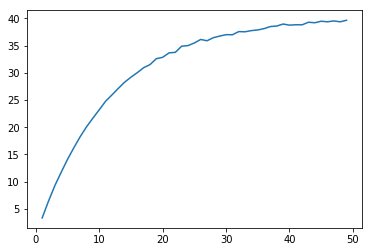

In [18]:
# a game of dice
import random
import matplotlib.pyplot as plt

def roll(bank): # roll dice and return win/loss
    res = random.randint(1,6)
    if res == 1:
        return -bank/2
    return res

if __name__=="__main__":
    nruns = 10000
    y = []
    for stop in range(1,50):
        thisres = 0.
        for k in range(nruns):
            bank = 0
            for i in range(stop):
                bank += roll(bank)
            thisres += bank
        thisres /= nruns
        #print('rolls: %d -> %f' % (stop,thisres))
        y.append(thisres)
    _ = plt.plot(range(1,50), y, '-')
    plt.show()

In [7]:
# helper

if __name__=="__main__":
    colstr = ['AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD']
    fstr = '=CORREL(Fragebögen!$L$2:Fragebögen!$L$31465,Fragebögen!L$2:Fragebögen!L$31465)'
    for cc in colstr:
        thisstr = fstr.replace('$L','$'+cc)
        print(thisstr.replace('!L','!'+cc))

=CORREL(Fragebögen!$AU$2:Fragebögen!$AU$31465,Fragebögen!AU$2:Fragebögen!AU$31465)
=CORREL(Fragebögen!$AV$2:Fragebögen!$AV$31465,Fragebögen!AV$2:Fragebögen!AV$31465)
=CORREL(Fragebögen!$AW$2:Fragebögen!$AW$31465,Fragebögen!AW$2:Fragebögen!AW$31465)
=CORREL(Fragebögen!$AX$2:Fragebögen!$AX$31465,Fragebögen!AX$2:Fragebögen!AX$31465)
=CORREL(Fragebögen!$AY$2:Fragebögen!$AY$31465,Fragebögen!AY$2:Fragebögen!AY$31465)
=CORREL(Fragebögen!$AZ$2:Fragebögen!$AZ$31465,Fragebögen!AZ$2:Fragebögen!AZ$31465)
=CORREL(Fragebögen!$BA$2:Fragebögen!$BA$31465,Fragebögen!BA$2:Fragebögen!BA$31465)
=CORREL(Fragebögen!$BB$2:Fragebögen!$BB$31465,Fragebögen!BB$2:Fragebögen!BB$31465)
=CORREL(Fragebögen!$BC$2:Fragebögen!$BC$31465,Fragebögen!BC$2:Fragebögen!BC$31465)
=CORREL(Fragebögen!$BD$2:Fragebögen!$BD$31465,Fragebögen!BD$2:Fragebögen!BD$31465)


In [24]:
import openpyxl

def topn(l0, n): 
    resl = [] 
    for i in range(0, n):  
        max0 = -float('Inf')
        for j in range(len(l0)):      
            if l0[j] > max0: 
                max0 = l0[j]
        try:
            l0.remove(max0)
            resl.append(max0)
        except ValueError:
            resl.append(0.)
    return resl

def maindeppath(dtree, depth):
    return 0

if __name__=="__main__":
    #wb = openpyxl.load_workbook('Daten work 2016.xlsx')
    wb = openpyxl.load_workbook('tst0.xlsx')
    #print(wb.sheetnames)
    #print(wb['AnalysisRaw'].cell(row=3, column=3).value)
    keys = []
    correlvals = []
    mean = []
    stdev = []
    for i in range(3, 47): # keys, mean and stdev per key
        keys.append(wb['AnalysisRaw'].cell(row=i, column=2).value)
        mean.append(float(wb['AnalysisRaw'].cell(row=i, column=48).value))
        stdev.append(float(wb['AnalysisRaw'].cell(row=i, column=49).value))
    for i in range(3, 47): # correlations - row
        cline = []
        for j in range(3, 47):
            val = wb['AnalysisRaw'].cell(row=i, column=j).value
            if val != None:
                cline.append(float(val))
            else:
                cline.append(0.)
        correlvals.append(cline)
        
    #print(keys)
    #print(correlvals)
    
    deptree = []
    for i in range(3, 46): # correlations - row
        cline = []
        deptree.append(i-3)
        for j in range(i+1, 47): # for each correl, upper diagonal
            cline.append(correlvals[i-3][j-3])
        if len(cline) > 3:
            deptree.append(topn(cline, 3))
        else: # handle fewer than n correlations available
            slst = []
            for k in range(len(cline)):
                slst.append(cline[k])
            deptree.append(slst)
    print(deptree)

[0, [0.28837777978915696, 0.21511577355320088, 0.12773844966246223], 1, [0.1136799103822584, 0.08838353556281357, 0.05039867091573414], 2, [0.532327187990652, 0.49440661826011595, 0.48921487141871156], 3, [0.6673026498561854, 0.5868761676750688, 0.5238906652069224], 4, [0.41770678198897304, 0.4132619777205848, 0.38684204707875375], 5, [0.4408302956638474, 0.43877434033870416, 0.43598003098315247], 6, [0.641554748935673, 0.4237336048225129, 0.4140535232624593], 7, [0.5088360694610015, 0.4031372537276397, 0.3983276734421597], 8, [0.34057655902920214, 0.2951174442360295, 0.26476425376954277], 9, [0.40333404735104095, 0.38488517190242577, 0.36876541295132503], 10, [0.328454884244223, 0.3184492636496332, 0.313487541427311], 11, [0.5653592377115911, 0.4443373559951614, 0.44360122975343], 12, [0.3558989118356011, 0.32944899374700726, 0.323097898635265], 13, [0.4460728993175809, 0.430745966657534, 0.42568322841749034], 14, [0.40053011821572704, 0.3226289606746616, 0.31177169969912055], 15, [0.

In [22]:
def topn(l0, n): 
    resl = [] 
    for i in range(0, n):  
        max0 = -float('Inf')
        for j in range(len(l0)):      
            if l0[j] > max0: 
                max0 = l0[j]
        try:
            l0.remove(max0)
            resl.append(max0)
        except ValueError:
            resl.append(0.)
    return resl

if __name__=="__main__":
    ll = [0, 10, -5, 2, 4, 5, 6, 8, 9]
    print(topn(ll, 3))

[10, 9, 8]


In [42]:
import openpyxl

def topn(l0, n, offset): # assume l0 list of tuples (idx, cval)
    resl = []
    for i in range(0, n):  
        max0 = -float('Inf')
        maxj = 0
        for j in range(len(l0)):      
            if l0[j][1] > max0: 
                max0 = l0[j][1]
                maxj = j
        try:
            #l0.remove(max0)
            #del l0[maxj]
            l0[maxj] = (maxj, -float('Inf')) # to maintain index consistency
            resl.append((maxj+offset, max0))
        except ValueError:
            resl.append((maxj+offset, 0.))
    return resl

def maindeppath(istart, dtree, depth):
    cidx = istart
    resl = [cidx]
    for d in range(depth):
        mx = -float('inf')
        imx = 0
        for elem in dtree[cidx]:
            if elem[1] > mx:
                mx = elem[1]
                imx = elem[0]
        cidx = imx
        resl.append(cidx)
    return resl

if __name__=="__main__":
    #wb = openpyxl.load_workbook('Daten work 2016.xlsx')
    wb = openpyxl.load_workbook('tst0.xlsx')
    #print(wb.sheetnames)
    #print(wb['AnalysisRaw'].cell(row=3, column=3).value)
    keys = []
    correlvals = []
    mean = []
    stdev = []
    for i in range(3, 47): # keys, mean and stdev per key
        keys.append(wb['AnalysisRaw'].cell(row=i, column=2).value)
        mean.append(float(wb['AnalysisRaw'].cell(row=i, column=48).value))
        stdev.append(float(wb['AnalysisRaw'].cell(row=i, column=49).value))
    for i in range(3, 47): # correlations - row
        cline = []
        for j in range(3, 47):
            val = wb['AnalysisRaw'].cell(row=i, column=j).value
            if val != None:
                cline.append((j-3, float(val)))
            else:
                cline.append((j-3, 0.))
        correlvals.append(cline)
        
    #print(keys)
    #print(correlvals)
    
    deptree = []
    for i in range(3, 46): # correlations - row
        cline = []
        #deptree.append(i-3)
        for j in range(i+1, 47): # for each correl, upper diagonal
            cline.append(correlvals[i-3][j-3])
        if len(cline) > 3:
            deptree.append(topn(cline, 3, i-2))
        else: # handle fewer than n correlations available
            slst = []
            for k in range(len(cline)):
                slst.append(cline[k])
            deptree.append(slst)
    #print(deptree)
    print(maindeppath(2, deptree, 8))
    print(maindeppath(5, deptree, 5))
    print(maindeppath(35, deptree, 5))
    print(maindeppath(15, deptree, 5))

[2, 3, 7, 10, 16, 21, 26, 28, 36]
[5, 6, 7, 10, 16, 21]
[35, 36, 37, 38, 39, 40]
[15, 32, 33, 34, 37, 38]


In [ ]:
'''Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
Reaches 98.6% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 3s on CPU (core i7).
'''
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',

    'two_arg_relations_10k': 'tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_{}.txt',

    'qa6_yes_no_ques_10k': 'tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_{}.txt',
}
challenge_type = 'qa6_yes_no_ques_10k'
challenge = challenges[challenge_type]

print('Extracting stories for the challenge:', challenge_type)
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[1])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=60,
          validation_data=([inputs_test, queries_test], answers_test))

# list all data in history
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


model_path1 = r'C:\Users\priya\Documents\my_dl\qachatbot\model6.h5'
model.save(model_path1)
#model save as pickle file
# model load again
# write story answer question in the format in a text file

model.load_weights(model_path1)
pred_results = model.predict(([inputs_test, queries_test]))
# Display a selected test story

n = np.random.randint(0,1000)
story_list = test_stories[n][0]
story =' '.join(word for word in story_list)
print("Story is:",story)

question_list = test_stories[n][1]
ques =' '.join(word for word in question_list)
print("Question is: ",ques)

ans = test_stories[n][2]
print("Actual answer is: ", ans)

#Generate prediction from model

val_max = np.argmax(pred_results[n])

for key, val in word_idx.items():
    if val == val_max:
        k = key

print("Machine answer is: ", k)
print("I am ", pred_results[n][val_max], "certain of it")

## Read my own file

# f = open(r"C:\Users\priya\Documents\my_dl\qachatbot\my_test_q2.txt", "r")
# print(f.readlines())
# data = parse_stories(f.readlines(), only_supporting=False)
# print(data)
# extra_stories = get_stories(f, only_supporting=False, max_length=None)
#
# print(extra_stories)

In [115]:
# end-to-end memory network

import numpy as np
from gensim import corpora
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

def lj(j, J, k, d): 
    return (1-j/J)-(k/d)*(1-2*j/J)

if __name__=="__main__":
    # load input data
    data = open('input1.txt', 'r').read() # input text file: sentences separated by .

    # hyperparameters
    d_embed = 10 # embedding dimension
    
    # input to memory embedding mi = A * xi + tA
        #stoplist = set('for a of the and to in'.split())
    stoplist = []
    doc_raw = 'sam walks into the kitchen. sam picks up an apple. sam walks into the bedroom. sam drops the apple.'
    query_raw = 'where is sam'
    document = doc_raw.split('.')
    document.append(query_raw)
    senttoken = [ [word for word in sentence.lower().split(' ') if word not in stoplist] for sentence in document ]
    dictionary = corpora.Dictionary(senttoken)
    #print(dictionary.token2id)
    document.pop(len(document)-1) # query at the end of document
    d_embed = len(dictionary)
    voc = 0 # size of vocabulary
    for d in document:
        #print(d)
        if len(d) == 0:
            document.remove(d)
        voc = max(voc, len(d.split()))
    n_memories = len(document)
    #print(voc)
    #print(document)

    # initiate weigth matrices
    A = np.random.randn(d_embed, voc)*0.01 # input to memory embedding
    tA = np.zeros(d_embed) # temporal encoding A
    B = np.random.randn(d_embed, voc)*0.01 # query embedding
    tB = np.zeros(d_embed) # temporal encoding B
    C = np.random.randn(d_embed, voc)*0.01 # output to memory embedding
    tC = np.zeros(d_embed) # temporal encoding C
    W = np.random.randn(voc, d_embed)*0.01 # final weight matrix 
    
    # embedding simple: m_i = A_ij * x_ij + T_A_j
    x = np.zeros((n_memories, voc))
    m = np.zeros((n_memories, d_embed))
    for i in range(n_memories):
        thissent = document[i].split()
        for j in range(len(thissent)):
            x[i][j] = dictionary.token2id[thissent[j]]
    for i in range(n_memories):
        m[i] = np.dot(A, x[i].T) + tA # simple embedding
        #m[i][j] = lj(j,len(document[i]),j,d_embed) * A[i][j] * x[i][j] + tA[j] # with positional encoding
    #print(x)
    #print(m)
    
    # query embedding u = B * q + tB
    q = np.zeros(voc)
    u = np.zeros(d_embed)
    thissent = query_raw.split()
    for j in range(len(thissent)):
        q[j] = dictionary.token2id[thissent[j]]
    u = np.dot(B, q) + tB
    
    # match of query with memory p = softmax(u * mi) for all i
    p = np.zeros((n_memories, d_embed))
    p = softmax(np.dot(u, m.T))
    #print(p)
    
    # output corresponding to input xi: ci = C * xi + tC
    c = np.zeros((n_memories, d_embed))
    for i in range(n_memories):
        c[i] = np.dot(C, x[i].T) + tC
    #print(c)
            
    # response vector from memory o = sum pi * ci
    o = np.zeros(d_embed)
    o = np.dot(p.T, c)
    #print(o)
    
    # predicted label a = softmax( W * (o + u))
    a_predict = softmax(np.dot(W, (o + u)))
    print(a_predict)

[0.19967251 0.20204188 0.20073461 0.19956787 0.19798314]


In [9]:
# end-to-end memory network

import numpy as np
from gensim import corpora
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

def lj(j, J, k, d): 
    return (1-j/J)-(k/d)*(1-2*j/J)

if __name__=="__main__":
    # load input data
    #data = open('input1.txt', 'r').read() # input text file: sentences separated by .

    # hyperparameters
    d_embed = 10 # embedding dimension
    lr = 0.1 # learning rate
    
    # input to memory embedding mi = A * xi + tA
        #stoplist = set('for a of the and to in'.split())
    stoplist = []
    doc_raw = 'sam walks into the kitchen. sam picks up an apple. sam walks into the bedroom. sam drops the apple.'
    query_raw = 'where is sam'
    document = doc_raw.split('.')
    document.append(query_raw)
    senttoken = [ [word for word in sentence.lower().split(' ') if word not in stoplist] for sentence in document ]
    dictionary = corpora.Dictionary(senttoken)
    print(dictionary.token2id)
    document.pop(len(document)-1) # query at the end of document
    d_embed = len(dictionary)
    #voc = 0 # size of vocabulary
    #for d in document:
        #print(d)
        #if len(d) == 0:
            #document.remove(d)
        #voc = max(voc, len(d.split()))
    voc = d_embed
    n_memories = len(document)
    #print(voc)
    #print(document)

    # initiate weigth matrices
    A = np.random.randn(d_embed, voc)*0.01 # input to memory embedding
    tA = np.zeros(d_embed) # temporal encoding A
    B = np.random.randn(d_embed, voc)*0.01 # query embedding
    tB = np.zeros(d_embed) # temporal encoding B
    C = np.random.randn(d_embed, voc)*0.01 # output to memory embedding
    tC = np.zeros(d_embed) # temporal encoding C
    W = np.random.randn(voc, d_embed)*0.01 # final weight matrix
    
    for iterctr in range(10000):

        # forward pass

        # embedding simple: m_i = A_ij * x_ij + T_A_j
        x = np.zeros((n_memories, voc))
        m = np.zeros((n_memories, d_embed))
        for i in range(n_memories):
            thissent = document[i].split()
            for j in range(len(thissent)):
                x[i][j] = dictionary.token2id[thissent[j]]
        for i in range(n_memories):
            m[i] = np.dot(A, x[i].T) + tA # simple embedding
            #m[i][j] = lj(j,len(document[i]),j,d_embed) * A[i][j] * x[i][j] + tA[j] # with positional encoding
        #print(x)
        #print(m)

        # query embedding u = B * q + tB
        q = np.zeros(voc)
        u = np.zeros(d_embed)
        thissent = query_raw.split()
        for j in range(len(thissent)):
            q[j] = dictionary.token2id[thissent[j]]
        u = np.dot(B, q) + tB

        # match of query with memory p = softmax(u * mi) for all i
        p = np.zeros((n_memories, d_embed))
        p = softmax(np.dot(u, m.T))

        # output corresponding to input xi: ci = C * xi + tC
        c = np.zeros((n_memories, d_embed))
        for i in range(n_memories):
            c[i] = np.dot(C, x[i].T) + tC

        # response vector from memory o = sum pi * ci
        o = np.zeros(d_embed)
        o = np.dot(p.T, c)

        # predicted label a = softmax( W * (o + u))
        a_predict = softmax(np.dot(W, (o + u)))
        #print(a_predict)

        # backpropagation

        dA = np.zeros_like(A)
        dB = np.zeros_like(B)
        dC = np.zeros_like(C)
        dW = np.zeros_like(W)
        dtA = np.zeros_like(tA)
        dtB = np.zeros_like(tB)
        dtC = np.zeros_like(tC)

        truth = np.zeros_like(tA)
        truth[10] = 1 # bedroom
        dy = a_predict - truth
        # dA = dy a_predict * (1-a_predict) W sumi p[i] (1-p[i]) ( u.T * 1A * x[i]) c[i]
        #print('V: %d' % (voc))
        #print('d: %d', (d_embed))
        ABCunit = np.pad(np.identity(voc), ((0,d_embed-voc),(0,0)), 'constant', constant_values=(0))
        Wunit = np.pad(np.identity(voc), ((0,0), (0,d_embed-voc)), 'constant', constant_values=(0))
        tunit = np.ones_like(tA)

        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(u, np.dot(ABCunit, x[i].T)), c[i])
        dEAtmp = W * dEAtmp
        dA = (np.dot(dy, a_predict * (1-a_predict)) * dEAtmp).T
        #print(dA)

        # dB = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) ((1B q).T m[i]) c[i] + 1B q)
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(np.dot(ABCunit, q), m[i]), c[i])
        dEAtmp = W * dEAtmp
        dB = (np.dot(dy, a_predict*(1-a_predict)) * dEAtmp).T
        #print(dB)

        # dC = dy a_predict * (1-a_predict) W sumi p[i] 1C x[i]
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*np.dot(ABCunit, x[i])
        dEAtmp = W * dEAtmp
        dC = (np.dot(dy, a_predict*(1-a_predict)) * dEAtmp).T
        #print(dC)

        # dW = dy a_predict * (1-a_predict) (o + u)
        dW = (np.dot(dy, a_predict*(1-a_predict)) * Wunit * (o + u))
        #print(dW)   

        # dtA = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) (u.T 1tA) c[i])
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*np.dot(np.dot(u.T, tunit), c[i])
        dtA = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtA)

        # dtB = dy a_predict * (1-a_predict) W ( sumi p[i] (1-p[i]) ((1tB).T m[i] c[i]) + 1tB)
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*(1.-p[i])*(np.dot(np.dot(tunit.T, m[i]), c[i]) + tunit)
        dtB = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtB)

        # dtC = dy a_predict * (1-a_predict) W ( sumi p[i] 1tC )
        dEAtmp = 0.
        for i in range(n_memories):
            dEAtmp += p[i]*tunit
        dtC = (np.dot(dy * a_predict * (1-a_predict), W) * dEAtmp).T
        #print(dtC)

        # maybe clip ?

        # update weights
        for weights, dweights in zip([A,B,C,W,tA,tB,tC], [dA,dB,dC,dW,dtA,dtB,dtC]):
            weights += -lr * dweights

        #print(A)
    #print(a_predict)
    #print(np.argmax(a_predict))
    print(dictionary[np.argmax(a_predict)])

{'into': 0, 'kitchen': 1, 'sam': 2, 'the': 3, 'walks': 4, '': 5, 'an': 6, 'apple': 7, 'picks': 8, 'up': 9, 'bedroom': 10, 'drops': 11, 'is': 12, 'where': 13}
bedroom


In [10]:
import numpy as np

v0 = np.array([1,2])
v1 = np.array([2,3])
W = np.array([[2,3],[1,4]])
v0 * v1 * W

array([[ 4, 18],
       [ 2, 24]])